In [74]:
import numpy as np
import pandas as pd
import json

import matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns


import time

plt.style.use('classic')
plt.style.use( 'seaborn-v0_8-white',)
sns.set_style("whitegrid", {'legend.frameon':True})

In [2]:
from dataclasses import dataclass


@dataclass
class OutputData:
    features: pd.DataFrame
    output: pd.DataFrame


def get_dataset(path: str):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [83]:
# json_dataset = get_dataset('./datasets/linear/data_25_000.json') +\
#             get_dataset('./datasets/linear/data_30_000.json') +\
#             get_dataset('./datasets/linear/data_35_000.json') +\
#             get_dataset('./datasets/linear/data_50_000.json') +\
#             get_dataset('./datasets/linear/data_55_000.json') +\
#             get_dataset('./datasets/linear/data_150_000.json')   
json_dataset = get_dataset('./datasets/fraction/data_10000_32_fraction.json') +\
               get_dataset('./datasets/fraction/data_80000_32_fraction.json') 
df = pd.json_normalize(json_dataset)

columns_rename = {
    ## service params
    'inp.services.cv': 'services_cv',
    'inp.services.skew': 'services_skew',
    'inp.services.rate_min': 'services_rate_min',
    'inp.services.rate_max': 'services_rate_max',
    ## arrival params
    'inp.arrival.skew': 'arrival_skew',
    'inp.arrival.cv': 'arrival_cv',
    'inp.arrival.rate': 'arrival_rate',
    ## num servers
    'inp.num_servers': 'num_servers',
    ## capacity
    'inp.capacity': 'capacity',
    'inp.num_slow_servers': 'num_slow_servers',
    ## meta info
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_skew': 'meta_arrival_skew',
    'meta.fitted.arrival_lag': 'meta_arrival_lag',
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_order': 'meta_arrival_order',
    'meta.fitted.service_cv': 'meta_service_cv',
    'meta.fitted.service_skew': 'meta_service_skew',
    'meta.fitted.service_order': 'meta_service_order',
    ## output
    'out.max_system_size.avg': 'out_max_system_size_avg',
    'out.max_system_size.std': 'out_max_system_size_std',
    'out.max_system_size.index': 'out_max_system_size_index',
    'out.min_system_size.avg': 'out_min_system_size_avg',
    'out.min_system_size.std': 'out_min_system_size_std',
    'out.min_system_size.index': 'out_min_system_size_index',
    'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
    'out.max_busy_rate.std': 'out_max_busy_rate_std',
    'out.max_busy_rate.index': 'out_max_busy_rate_index',
    'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
    'out.min_busy_rate.std': 'out_min_busy_rate_std',
    'out.min_busy_rate.index': 'out_min_busy_rate_index',
    'out.loss_prob': 'out_los_prob',
    'out.response_time.avg': 'out_response_time_avg',
    'out.response_time.std': 'out_response_time_std',
    'out.response_time.index': 'out_response_time_index'
}

df = df.rename(columns=columns_rename, inplace=False)
df = df.loc[df['out_response_time_avg'] < 20]
df = df.loc[df['meta_arrival_skew'] < 100]
df = df.loc[df['meta_service_skew'] < 100]

data = OutputData(
    features=df[[
                 'meta_service_skew', 
                 'meta_service_cv', 
                 'services_rate_min', 
                 'services_rate_max',
                 'meta_arrival_skew',
                 'meta_arrival_cv', 
                 'arrival_rate',
                 'num_servers',
                 'capacity',
                 'num_slow_servers'
    ]],
    output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
    ]]
)

## TODO remove input_type and lag from df
data

OutputData(features=       meta_service_skew  meta_service_cv services_rate_min services_rate_max  \
0                  23.98             4.25             31.37             44.10   
1                  42.58             4.84              8.55             40.68   
2                  20.14             2.57              8.18             20.52   
3                  38.55             2.74              8.22             34.67   
4                  30.00             2.70              1.63             32.36   
...                  ...              ...               ...               ...   
89977              34.03             2.63             39.80             46.32   
89978              37.32             3.88              0.84             15.28   
89979              61.34             1.03              6.31             16.66   
89980              72.87             2.76             10.97             43.93   
89981              67.20             3.76             11.31             48.19   

       

In [58]:
COLORS_MAP = {
    'green': ["Greens", 'lightgreen'],
    'blue': ["Blues", 'lightblue'],
    'orange': ["Oranges", "#fed8b1"],
    'purple': ['Purples', '#D8BFD8']
}


def build_estimates_tests_scatter(estimations, predictions,
                                  name="", 
                                  rang=[0, 10], 
                                  divider=1,
                                  xlabel='samples_s', 
                                  ylabel='sstimates_s',
                                  color='blue'):
    
    fig , ax = plt.subplots(figsize=(5, 5))
    cm = plt.get_cmap(COLORS_MAP.get(color)[0])
    col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
    plt.scatter(predictions, estimations, c=col, marker='^', linewidth=0.2)
    x = np.linspace(rang[0], rang[1])
    plt.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
    plt.title('{}'.format(name), fontsize=22, pad=10)
    ax.title.set_fontsize(24)
    plt.xticks()
    plt.tick_params(labelsize=22)
    plt.yticks()

    plt.xlim(rang)
    plt.ylim(rang)

    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)

In [59]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

def regression_report(y_true, y_pred):
    return {
        "corr": corr(y_true, y_pred),
        "r2_score": r2_score(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred)
    }

## loss prob regression

In [60]:
loss_prob = data.output['out_los_prob']
loss_prob

0        0.479111
1        0.374739
2        0.743337
3        0.009762
4        0.942407
           ...   
89977    0.620742
89978    0.078540
89979    0.616418
89980    0.451767
89981    0.664372
Name: out_los_prob, Length: 87543, dtype: float64

In [61]:
data.features

,meta_service_skew,meta_service_cv,services_rate_min,services_rate_max,meta_arrival_skew,meta_arrival_cv,arrival_rate,num_servers,capacity,num_slow_servers
0,23.98,4.25,31.37,44.10,79.41,0.92,28.12,13,17,3
1,42.58,4.84,8.55,40.68,43.54,4.27,12.02,27,16,0
2,20.14,2.57,8.18,20.52,73.75,4.79,16.67,31,8,5
3,38.55,2.74,8.22,34.67,10.76,3.19,2.91,4,8,0
4,30.00,2.70,1.63,32.36,59.45,1.02,11.67,29,8,21
...,...,...,...,...,...,...,...,...,...,...
89977,34.03,2.63,39.80,46.32,14.54,4.21,25.59,23,4,15
89978,37.32,3.88,0.84,15.28,42.20,1.99,0.40,2,3,1
89979,61.34,1.03,6.31,16.66,42.33,0.65,11.87,9,2,4
89980,72.87,2.76,10.97,43.93,95.94,3.41,13.40,10,14,9


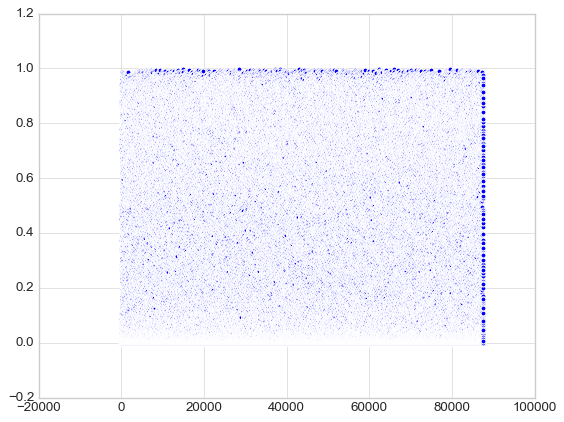

In [62]:
d = loss_prob
y = list(float(i) for i in d)
x = range(0, len(y))
plt.scatter(x, y)

## Prepare x_train and x_test

In [63]:
scaler = StandardScaler()
scaler.fit(data.features)
features = scaler.transform(data.features)

X_train, X_test, y_train, y_test = train_test_split(features, loss_prob, train_size=0.8)

## Regression tree

In [64]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = {
                'criterion': ['mse', 'mae'],
                'max_depth':[4,6,8,9,10,15,20]
}

gs = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    tree_params,
    verbose=1,
    cv=10,
    n_jobs=4
)

#regressor = DecisionTreeRegressor(random_state=0)
#cross_val_score(regressor, df, y_busy_services, cv=10)

#gs.fit(df, y_busy_services)

start_time = time.time()
tree = DecisionTreeRegressor(criterion='absolute_error', max_depth=12)
print("Time for calculation decision tree {}".format(time.time() - start_time))

tree.fit(X_train, y_train)
#print(regression_report(y_test, tree.predict(X_test)))

Time for calculation decision tree 8.225440979003906e-05


DecisionTreeRegressor(criterion='absolute_error', max_depth=12)

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/2451832914.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]


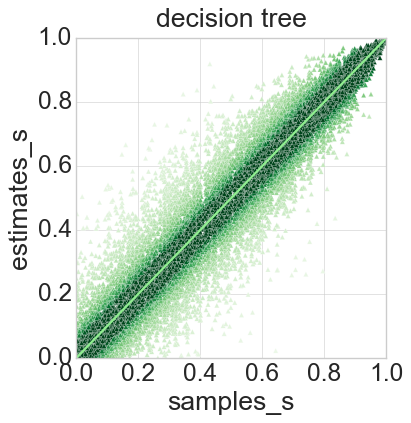

In [66]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="decision tree", 
    color="green",
    rang=[0, 1], 
    divider=20, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)

In [67]:
print(regression_report(y_test, tree.predict(X_test)))

{'corr': 0.9632381768513045, 'r2_score': 0.9271599785110656, 'mse': 0.007383340297490784}


## Gradient boosting

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#grb_estimation_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(max_depth=18, n_estimators=1000))

grb_estimation_pipe = GradientBoostingRegressor()

tree_params = {
    'loss': ['squared_error'],
    'criterion': ['squared_error'],
    'max_depth': [6, 8, 10],
    'n_estimators': [600, 800, 1000]
}

start_time = time.time()
#grb_estimation_pipe.fit(X_train, y_train) 

gs = GridSearchCV(
    grb_estimation_pipe,
    param_grid=tree_params,
    n_jobs=6,
    cv=4
)


gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

#print("Time for calculation gradient boosting {}".format(time.time() - start_time))

{'criterion': 'squared_error', 'loss': 'squared_error', 'max_depth': 8, 'n_estimators': 1000}
0.9913546683083521


{'corr': 0.9963137306971229, 'r2_score': 0.9925965069579491, 'mse': 0.0007504460789851808}


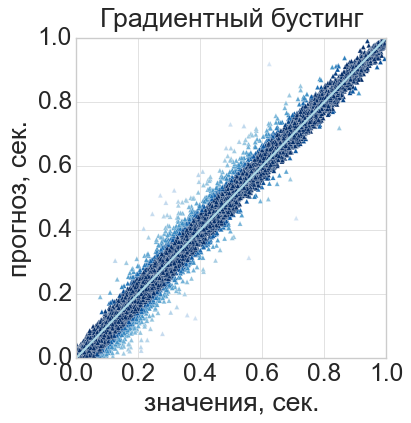

In [69]:
build_estimates_tests_scatter(
    y_test.values,
    gs.predict(X_test), 
    name="Градиентный бустинг", 
    color="blue",
    rang=[0, 1], divider=20, 
    xlabel="значения", 
    ylabel="прогноз"
)
print(regression_report(y_test, gs.predict(X_test)))

## Neural network

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import time

import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class LinearRegressionNet(nn.Module):
    def __init__(self, features_count, outputs_count):
        super().__init__()
        self.linear1 = nn.Linear(features_count, 128)
        self.act1 = nn.LeakyReLU()
        self.batchnorm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, outputs_count)
        self.act2 = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.batchnorm(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x

loss_fn = F.mse_loss
inputs = torch.from_numpy(X_train).type(torch.float32)
targets = torch.from_numpy(y_train.to_numpy()).type(torch.float32)
targets = targets.reshape((targets.size(0), 1))

train_ds = TensorDataset(inputs, targets)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size, shuffle=False)
rt_model = LinearRegressionNet(inputs.shape[1], 1)
opt = torch.optim.Adam(rt_model.parameters(), lr=0.001)

losses = []
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward() 
            opt.step()
            opt.zero_grad()
        losses.append(loss_fn(model(xb), yb).detach().flatten()[0])    
        if epoch % 100 == 0:    
            print('Epoch {}: Training loss: {}'.format(epoch, loss_fn(model(xb), yb)))    
    print('Training loss: ', loss_fn(model(inputs), targets))

# learning model

start_time = time.time()
rt_model.train()
fit(1000, rt_model, loss_fn, opt)
print("Time for calculation learing neural network {}".format(time.time() - start_time))

torch.no_grad()
rt_model.eval()

cpu
Epoch 0: Training loss: 0.01491700392216444
Epoch 100: Training loss: 0.0013624862767755985
Epoch 200: Training loss: 0.0012108800001442432
Epoch 300: Training loss: 0.001088447286747396
Epoch 400: Training loss: 0.000988460611552
Epoch 500: Training loss: 0.0009391620405949652
Epoch 600: Training loss: 0.0009422706789337099
Epoch 700: Training loss: 0.0009546052897349
Epoch 800: Training loss: 0.0009777520317584276
Epoch 900: Training loss: 0.0009854291565716267
Training loss:  tensor(0.0009, grad_fn=<MseLossBackward0>)
Time for calculation learing neural network 769.3258590698242


LinearRegressionNet(
  (linear1): Linear(in_features=10, out_features=128, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (act2): ReLU()
)

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/2451832914.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]


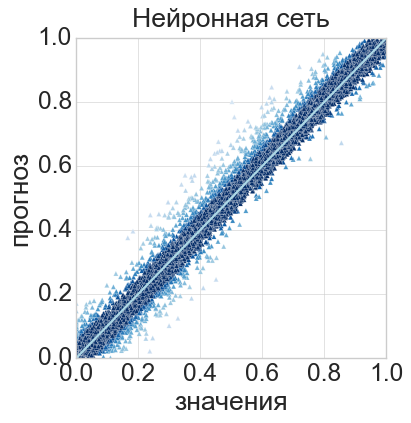

In [71]:
build_estimates_tests_scatter(y_test.to_numpy().flatten(), 
                              rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten(),
                              name="Нейронная сеть",
                              xlabel="значения", 
                              ylabel="прогноз",
                              rang=[0, 1], divider=20)

In [72]:
regression_report(y_test.to_numpy().flatten(), rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten())

{'corr': 0.9957258205780684,
 'r2_score': 0.9909394632378735,
 'mse': 0.0009184103028150261}

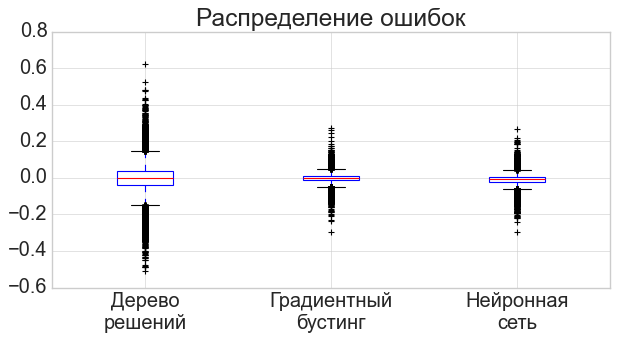

In [79]:
all_data = [
    tree.predict(X_test).flatten() - y_test.to_numpy(),
    gs.predict(X_test).flatten() - y_test.to_numpy(),
    rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten() - y_test
]

fig, ax = plt.subplots(figsize=(9, 4))
labels = ["Дерево\nрешений", "Градиентный\nбустинг", "Нейронная\nсеть"]
# rectangular box plot
bplot = ax.boxplot(all_data,
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels)  # will be used to label x-ticks
ax.set_title("Распределение ошибок", fontsize=22)
ax.tick_params(labelsize=18)
fig.savefig('loss_prob_errors.png',  bbox_inches="tight")

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/1048714973.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/1048714973.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]


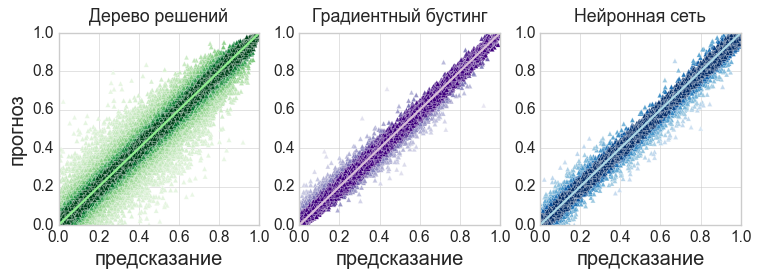

In [78]:
def build_estimates_tests_scatter_all():
    
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))

    def render_plot(
        ax, 
        predictions,
        estimations,
        name="", 
        rang=[0, 20], 
        color='red',
        divider=1,
    ):
        cm = plt.get_cmap(COLORS_MAP.get(color)[0])
        col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
        ax.scatter(predictions, estimations, c=col, marker='^', linewidth=0.2)
        x = np.linspace(rang[0], rang[1])
        ax.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
        ax.set_title('{}'.format(name), fontsize=16, pad=10)
        #ax.set_tick_params(labelsize=22)    
        
        ax.set_xlim(rang)
        ax.set_ylim(rang)

        ax.tick_params(axis='both', which='major', labelsize=14)

        ax.set_xlabel("предсказание", size=18)
        if name == 'Дерево решений':
            ax.set_ylabel("прогноз", size=18)

    render_plot(
        ax1, 
        y_test.values,
        tree.predict(X_test), 
        name="Дерево решений", 
        color="green",
        rang=[0, 1], 
        divider=20
    )
    render_plot(
        ax2, 
        y_test.values,
        gs.predict(X_test), 
        name="Градиентный бустинг", 
        color="purple",
        rang=[0, 1], 
        divider=20
    )
    render_plot(
        ax3, 
        y_test.values,
        rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten(),
        name="Нейронная сеть", 
        color="blue",
        rang=[0, 1], 
        divider=20
    )
    
    fig.savefig('loss_prob_scatter.png',  bbox_inches="tight")
    
build_estimates_tests_scatter_all()

## Validation

In [87]:
# json_dataset = get_dataset('./datasets/linear/data_25_000.json') +\
#             get_dataset('./datasets/linear/data_30_000.json') +\
#             get_dataset('./datasets/linear/data_35_000.json') +\
#             get_dataset('./datasets/linear/data_50_000.json') +\
#             get_dataset('./datasets/linear/data_55_000.json') +\
#             get_dataset('./datasets/linear/data_150_000.json')   
def get_dataset_results(paths):
    json_dataset = []
    for path in paths:
        json_dataset += get_dataset(path)

    df = pd.json_normalize(json_dataset)

    columns_rename = {
        ## service params
        'inp.services.cv': 'services_cv',
        'inp.services.skew': 'services_skew',
        'inp.services.rate_min': 'services_rate_min',
        'inp.services.rate_max': 'services_rate_max',
        ## arrival params
        'inp.arrival.skew': 'arrival_skew',
        'inp.arrival.cv': 'arrival_cv',
        'inp.arrival.rate': 'arrival_rate',
        ## num servers
        'inp.num_servers': 'num_servers',
        ## capacity
        'inp.capacity': 'capacity',
        'inp.num_slow_servers': 'num_slow_servers',
        ## meta info
        'meta.fitted.arrival_cv': 'meta_arrival_cv',
        'meta.fitted.arrival_skew': 'meta_arrival_skew',
        'meta.fitted.arrival_lag': 'meta_arrival_lag',
        'meta.fitted.arrival_cv': 'meta_arrival_cv',
        'meta.fitted.arrival_order': 'meta_arrival_order',
        'meta.fitted.service_cv': 'meta_service_cv',
        'meta.fitted.service_skew': 'meta_service_skew',
        'meta.fitted.service_order': 'meta_service_order',
        ## output
        'out.max_system_size.avg': 'out_max_system_size_avg',
        'out.max_system_size.std': 'out_max_system_size_std',
        'out.max_system_size.index': 'out_max_system_size_index',
        'out.min_system_size.avg': 'out_min_system_size_avg',
        'out.min_system_size.std': 'out_min_system_size_std',
        'out.min_system_size.index': 'out_min_system_size_index',
        'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
        'out.max_busy_rate.std': 'out_max_busy_rate_std',
        'out.max_busy_rate.index': 'out_max_busy_rate_index',
        'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
        'out.min_busy_rate.std': 'out_min_busy_rate_std',
        'out.min_busy_rate.index': 'out_min_busy_rate_index',
        'out.loss_prob': 'out_los_prob',
        'out.response_time.avg': 'out_response_time_avg',
        'out.response_time.std': 'out_response_time_std',
        'out.response_time.index': 'out_response_time_index'
    }

    df = df.rename(columns=columns_rename, inplace=False)
    df = df.loc[df['out_response_time_avg'] < 20]
    df = df.loc[df['meta_arrival_skew'] < 100]
    df = df.loc[df['meta_service_skew'] < 100]

    data = OutputData(
        features=df[[
                 'meta_service_skew', 
                 'meta_service_cv', 
                 'services_rate_min', 
                 'services_rate_max',
                 'meta_arrival_skew',
                 'meta_arrival_cv', 
                 'arrival_rate',
                 'num_servers',
                 'capacity',
                 'num_slow_servers'
        ]],
        output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
        ]]
    )

    return data

In [54]:
def build_validation_response_time_chart(
        data, 
        #tree_data, 
        boosting_data, 
        neural_network_data, 
        x_label, 
        title="", 
        range_=range(1, 11)
    ):
    
    plt.figure(figsize=(10, 5))
    
    sns.set_palette("Set1", 10)
    #plt.plot(range_, tree_data, label="decision tree", color="green")
    plt.plot(range_, data, 'o', label="simulation", linewidth=4, linestyle="dashed")
    plt.plot(range_, boosting_data, label="gradient boosting", linestyle="dotted", linewidth=4, marker="X")
    plt.plot(range_, neural_network_data, label="neural network", linewidth=4, marker="x")
    
    #plt.ylabel('response time, s', fontsize=24)
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel('вероятность потери', fontsize=26)
    plt.tick_params(labelsize=24)

    plt.legend(prop={'size': 24}, fontsize=48, edgecolor="grey", facecolor="white", frameon=False)

### by arrival intecity

In [101]:
import time

by_arrival_intecity = get_dataset_results(['./datasets/fraction/validation/by_arrival_res.json'])
scaled_features = scaler.transform(by_arrival_intecity.features)

current_time = time.time()
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
print(time.time() - current_time)
current_time = time.time()
tree.predict(scaled_features)
print(time.time() - current_time)
current_time = time.time()
gs.predict(scaled_features)
print(time.time() - current_time)


by_arrival_intecity = get_dataset_results(['./datasets/linear/validation/arrival_res.json'])
scaled_features = scaler.transform(by_arrival_intecity.features)
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_arrival_intecity.output['out_los_prob'],
    gs.predict(scaled_features),
    nn_results,
    'arrival lambda',
    range_=range(5, 51, 5)
)

0.0017600059509277344
0.0002701282501220703
0.0011229515075683594


KeyError: "['num_slow_servers'] not in index"

In [100]:
by_capacity = get_dataset_results(['./datasets/linear/validation/capacity_res.json'])
scaled_features = scaler.transform(by_capacity.features)
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_capacity.output['out_los_prob'],
    gs.predict(scaled_features),
    nn_results,
    'capacity',
    range_=range(2, 20, 2)
)

KeyError: "['num_slow_servers'] not in index"

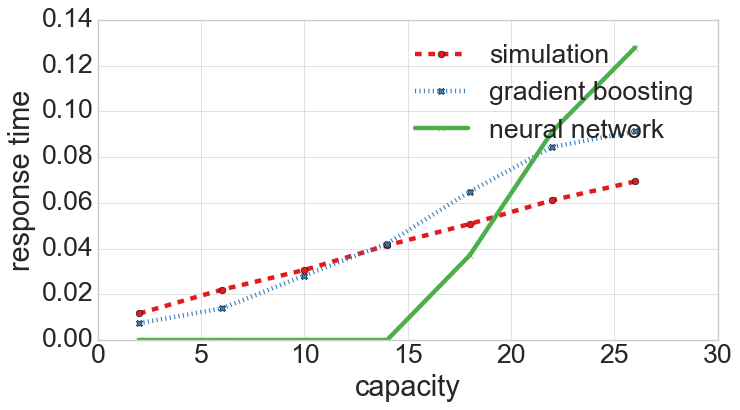

In [53]:
by_servers = get_dataset_results(['./datasets/linear/validation/servers_res.json'])
scaled_features = scaler.transform(by_servers.features)
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_servers.output['out_los_prob'],
    gs.predict(scaled_features),
    nn_results,
    'capacity',
    range_=range(2, 30, 4)
)

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/1480289305.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/1480289305.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_35068/1480289305.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", m

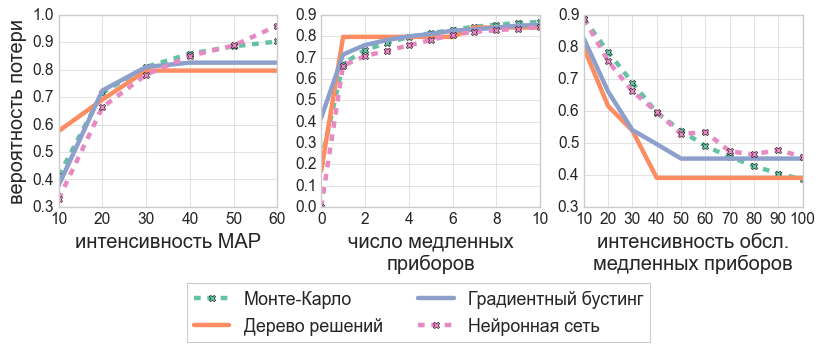

In [94]:
def build_validation_common():
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    sns.set_palette("Set2", 10)
    
    def build_single_chart(
        ax,
        data, 
        tree_data, 
        boosting_data, 
        neural_network_data, 
        x_label, 
        title="", 
        range_=range(1, 11)
    ):
        ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
        ax.plot(range_, tree_data, label="Дерево решений", linewidth=4)
        ax.plot(range_, boosting_data, label="Градиентный бустинг", linewidth=4)
        ax.plot(range_, neural_network_data, label="Нейронная сеть", linestyle="dashed", linewidth=4, marker="X")

        
        #plt.ylabel('response time, s', fontsize=24)
        ax.set_xlabel(x_label, fontsize=18)
        if x_label == 'интенсивность MAP':
            ax.set_ylabel('вероятность потери', fontsize=18)
            fig.legend(*ax.get_legend_handles_labels(), loc='lower center', 
                   bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize=16, frameon=True)
        ax.tick_params(axis='both', which='major', labelsize=14)



    by_arrival_intecity = get_dataset_results(['./datasets/fraction/validation/by_arrival_res.json'])
    scaled_features = scaler.transform(by_arrival_intecity.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)
    
    build_single_chart(
        ax1,
        by_arrival_intecity.output['out_los_prob'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'интенсивность MAP',
        range_=range(10, 70, 10)    
    )

    by_capacity = get_dataset_results(['./datasets/fraction/validation/by_slow_servers_res.json'])
    scaled_features = scaler.transform(by_capacity.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)

    build_single_chart(
        ax2,
        by_capacity.output['out_los_prob'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'число медленных\nприборов',
        range_=range(0, 11, 1)   
    )

    by_servers = get_dataset_results(['./datasets/fraction/validation/by_slow_server_intencity_res.json'])
    scaled_features = scaler.transform(by_servers.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_los_prob'], gs.predict(scaled_features)

    build_single_chart(
        ax3,
        by_servers.output['out_los_prob'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'интенсивность обсл.\nмедленных приборов',
        range_=range(10, 110, 10)  
    )
    fig.savefig('loss_prob_validation.png',  bbox_inches="tight")

build_validation_common()